In [2]:
import numpy as np
import string

In [3]:
def calculate_querschnittswerte(querschnitte: list) -> list:
    for qs in querschnitte:
       qs['A'] = qs['b']*qs['h']
       qs['I'] = qs['b']*qs['h']**3/12

    return querschnitte

def calculate_staebe(staebe: list, knoten: list) -> dict:
    for stab in staebe:
        dx_stab = knoten[stab['r']]['x'] - knoten[stab['l']]['x']
        dz_stab = knoten[stab['r']]['z'] - knoten[stab['l']]['z']
        stab['L'] = np.sqrt(dx_stab**2 + dz_stab**2)
        stab['alpha'] = np.degrees(np.arctan2(dx_stab, dz_stab)) - 90   # da Koordinatensystem gedreht
        stab['points'] = [x*stab['L']/(stab['elems']) for x in range(0,stab['elems']+1)]

    return staebe


#querschnitte = calculate_querschnittswerte(querschnitte)
#print(querschnitte)

In [4]:
def federn(db: dict) -> list:
    federn = []

    for i, knot in enumerate(db['sofimshc']['knoten']):
        for key, value in knot['sup'].items():
            if value > 0:
                federn.append({'knot': i, 'richtung': key, 'wert': value})

    return federn

In [6]:
def element_stiffness_matrix(EA: float, EI: float, l: float) -> list:
    u_delta = [EA/l, 0, 0]
    tau_l = [0, 4*EI/l, 2*EI/l]
    tau_r = [0, 2*EI/l, 4*EI/l]

    return [u_delta, tau_l, tau_r]   # Element-Steifigkeitsmatrix k_e

def stiffness_matrix(db:dict) -> np.matrix:
    k = []
    n_federn = len(db['sofimshc']['federn'])
    k_size = len(db['sofimshc']['staebe'])*3 + n_federn
    
    for i, stab in enumerate(db['sofimshc']['staebe']):
        k_e = element_stiffness_matrix(stab['EA'], stab['EI'], stab['L'])
        
        for j in range(3):
            k.append([0, 0, 0]*i + k_e[j] + [0]*(k_size-(i+1)*3))

    for i, feder in enumerate(db['sofimshc']['federn']):
        k.append([0]*(k_size-n_federn+i) + [feder['wert']] + [0]*(n_federn-i-1))

    return np.array(k)  # Steifigkeitsmatrix k

In [7]:
def total_stiffness_matrix(db: dict) -> np.matrix:
    return np.matmul(np.matmul(db['sofimshc']['wgv']['a'].transpose(), db['sofimshc']['wgv']['k']), db['sofimshc']['wgv']['a'])

In [53]:
def get_index(what: any, where: any):
    if what in where:
        return where.index(what)
    else:
        return None


def festhaltekraftgroessen(db: dict, lf_nr: int) -> np.array:
    s_0 = np.zeros(len(db['sofimshc']['wgv']['a']))
    lf = db['sofiload']['LF'][lf_nr]

    for stab in lf['stab']:      #TODO Temperatur gleichförmig, ungleichförmig, Einzellasten (mehrere superponieren)
        length = db['sofimshc']['staebe'][stab['nr']]['L']
        alpha = np.radians(db['sofimshc']['staebe'][stab['nr']]['alpha'])
        pos = stab['nr']*3

        s_0[pos] += -1/6*length*(stab['p_xl']+2*stab['p_xr'])           # N_r^0
        s_0[pos+1] += length**2/60*(3*stab['p_zl'] + 2*stab['p_zr'])    # M_l^0
        s_0[pos+2] += -length**2/60*(2*stab['p_zl'] + 3*stab['p_zr'])   # M_r^0

    return s_0


def ersatzknotenkraefte(db: dict, lf_nr: int) -> np.array:
    P_0 = np.zeros(len(db['sofimshc']['wgv']['a'][1]))
    lf = db['sofiload']['LF'][lf_nr]
    freiheitsgrade = db['sofimshc']['wgv']['knot_deform']

    for stab in lf['stab']:      #TODO Temperatur gleichförmig, ungleichförmig, Einzellasten (mehrere superponieren)
        length = db['sofimshc']['staebe'][stab['nr']]['L']
        alpha = np.radians(db['sofimshc']['staebe'][stab['nr']]['alpha'])

        knot_l = db['sofimshc']['staebe'][stab['nr']]['l']
        P_zl = length/6*(2*stab['p_zl'] + stab['p_zr'])
        P_xl = length/6*(2*stab['p_xl'] + stab['p_xr'])
        #TODO zuerst nach passendem Stab, dann nach allgemeinem Knoten suchen, nötig? -> nur für Normal und Querkraft?
        if (index := get_index((knot_l, 'x', stab['nr']), freiheitsgrade)) != None: 
             P_0[index] += np.sin(alpha)*P_zl + np.cos(alpha)*P_xl
        elif (index := get_index((knot_l, 'x'), freiheitsgrade)) != None: 
             P_0[index] += np.sin(alpha)*P_zl + np.cos(alpha)*P_xl

        if (index := get_index((knot_l, 'z', stab['nr']), freiheitsgrade)) != None: 
            P_0[index] += np.cos(alpha)*P_zl - np.sin(alpha)*P_xl  
        elif (index := get_index((knot_l, 'z'), freiheitsgrade)) != None: 
            P_0[index] += np.cos(alpha)*P_zl - np.sin(alpha)*P_xl

        knot_r = db['sofimshc']['staebe'][stab['nr']]['r']
        P_zr = length/6*(stab['p_zl'] + 2*stab['p_zr'])
        P_xr = length/6*(stab['p_xl'] + 2*stab['p_xr'])

        if (index := get_index((knot_r, 'x', stab['nr']), freiheitsgrade)) != None: 
            P_0[index] += np.sin(alpha)*P_zr + np.cos(alpha)*P_xr
        elif (index := get_index((knot_r, 'x'), freiheitsgrade)) != None: 
            P_0[index] += np.sin(alpha)*P_zr + np.cos(alpha)*P_xr

        if (index := get_index((knot_r, 'z', stab['nr']), freiheitsgrade)) != None: 
            P_0[index] += np.cos(alpha)*P_zr - np.sin(alpha)*P_xr 
        elif (index := get_index((knot_r, 'z'), freiheitsgrade)) != None: 
            P_0[index] += np.cos(alpha)*P_zr - np.sin(alpha)*P_xr 

    return P_0


def knotenkraefte(db: dict, lf_nr: int) -> np.array:
    P_quer = np.zeros(len(db['sofimshc']['wgv']['a'][1]))
    lf = db['sofiload']['LF'][lf_nr]
    freiheitsgrade = db['sofimshc']['wgv']['knot_deform']

    for knot in lf['knot']:      #TODO Auflagersenkung, -drehung
        if knot['type'] == 'F':
            if (index := get_index((knot['nr'], 'x'), freiheitsgrade)) != None: 
                P_quer[index] += -np.cos(alpha)*knot['val']
            if (index := get_index((knot['nr'], 'z'), freiheitsgrade)) != None:
                P_quer[index] += np.sin(alpha)*knot['val']

        if knot['type'] == 'M':         #TODO Warnung, dass Last nicht eindeutig aufgebracht werden kann, wenn Vollgelenk
            if (index := get_index((knot['nr'], 'y'), freiheitsgrade)) != None:
                P_quer[index] += knot['val']

    return P_quer

In [9]:
def load_vector(db: dict, lf: int) -> np.array:
    arrays = db['sofiload']['LF'][lf]['wgv']
    return arrays['P_quer'] + arrays['P_0'] - np.transpose(db['sofimshc']['wgv']['a']).dot(arrays['s_0']) # P

In [10]:
# kein return: diese Funktionen allein für Manipulation der DB verantwortlich
# für alle: Eingabedatei in db umsetzen

def calculate_aqua(db: dict):
    #calculate_querschnittswerte()
    pass    # Querschnitte: Fläche und Trägheitsmoment



def calculate_sofimshc(db: dict):
    # EI und EA berechnen, falls nicht explizit vorgegeben
    db['sofimshc']['staebe'] = calculate_staebe(db['sofimshc']['staebe'], db['sofimshc']['knoten'])
    db['sofimshc']['federn'] = federn(db)

    db['sofimshc']['wgv'] = dict()
    a, pos = kinematic_transformation_matrix(db)
    db['sofimshc']['wgv']['a'] = a
    db['sofimshc']['wgv']['knot_deform'] = pos

    db['sofimshc']['wgv']['k'] = stiffness_matrix(db)
    db['sofimshc']['wgv']['K'] = total_stiffness_matrix(db)
 


def calculate_sofiload(db: dict):
    for item in db['sofiload']['LF'].items():
        db['sofiload']['LF'][item[0]]['wgv'] = dict()
        db['sofiload']['LF'][item[0]]['wgv']['s_0'] = festhaltekraftgroessen(db, item[0])
        db['sofiload']['LF'][item[0]]['wgv']['P_0'] = ersatzknotenkraefte(db, item[0])
        db['sofiload']['LF'][item[0]]['wgv']['P_quer'] = knotenkraefte(db, item[0])
        db['sofiload']['LF'][item[0]]['wgv']['P'] = load_vector(db, item[0])



def calculate_ase(db:dict):
    for item in db['ase'].items():
        if item[1] == None:
            db['ase'][item[0]] = dict()
            db['ase'][item[0]] = dict()
            db['ase'][item[0]]['V'] = knot_deformations(db, item[0])
            db['ase'][item[0]]['v'] = stabendweggroessen(db, item[0])
            db['ase'][item[0]]['s_II'] = stabendkraftgroessen(db, item[0])
            db['ase'][item[0]]['s_I'] = convert_kraftgroessen(db['ase'][item[0]]['s_II'])
            db['ase'][item[0]]['s'] = schnittgroessen(db, item[0])
            # WGV auflösen, Schnittgrößen speichern



def calculate_maxima(db: dict):
    pass    # Überlagerungsvorschrift, Werte an allen Teilungspunkten bestimmen (max, min; N, M, Q) (was gewünscht)



def calculate_aqb(db: dict):
    pass    # Bemessung? notwendig?



In [11]:
def knot_deformations(db: dict, lf: int) -> np.array:
    return np.linalg.inv(db['sofimshc']['wgv']['K']).dot(db['sofiload']['LF'][lf]['wgv']['P'])

def stabendweggroessen(db: dict, lf: int) -> np.array:
    return db['sofimshc']['wgv']['a'].dot(db['ase'][lf]['V'])

def stabendkraftgroessen(db: dict, lf: int) -> np.array:
    return db['sofimshc']['wgv']['k'].dot(db['ase'][lf]['v']) + db['sofiload']['LF'][lf]['wgv']['s_0']

def convert_kraftgroessen(s_II: np.array) -> np.array:
    n_staebe = len(db['sofimshc']['staebe'])
    s_I = np.copy(s_II)
    for i in range(1,n_staebe*2+2,3):
        s_I[i] *= -1
    return s_I

def schnittgroessen(db: dict, lf: int) -> dict:
    staebe = db['sofimshc']['staebe']
    n_staebe = len(staebe)
    s = db['ase'][lf]['s_I']
    loads = db['sofiload']['LF'][lf]['stab']
    s_staebe = {}

    for i, stab in enumerate(staebe):       
        s_staebe[i] = dict()
        length = stab['L']

        # Schnittgrößen infolge Stabendkraftgrößen
        s_staebe[i]['N'] = [s[i*3]]*(stab['elems']+1)
        s_staebe[i]['M'] = [s[i*3+1]*(1-x/length)+s[i*3+2]*x/length for x in stab['points']]
        s_staebe[i]['V'] = [(s[i*3+2]-s[i*3+1])/length]*(stab['elems']+1)

    for load in loads:
        stab = load['nr']
        length = staebe[stab]['L']
        p_xl, p_xr = load['p_xl'], load['p_xr']
        p_zl, p_zr = load['p_zl'], load['p_zr']
        for i, x in  enumerate(staebe[stab]['points']):
            s_staebe[stab]['N'][i] += 1/2*((p_xr-p_xl)/length*x**2 + 2*p_xl*x - (p_xl+p_xr)*length)
            s_staebe[stab]['M'][i] += length**2/6*(((1-x/length) - (1-x/length)**3)*p_zl + (x/length -(x/length)**3)*p_zr)
            s_staebe[stab]['V'][i] += 1/2*(-(p_zr-p_zl)/length*x**2 - 2*p_zl*x + 1/3*(2*p_zl+p_zr)*length)

            
    return s_staebe

# Eingabe

In [51]:
def kinematic_transformation_matrix(db: dict) -> tuple:
    a_T = []    # transponierte Transformationsmatrix
    pos = []    # Stelle und Richtung der einzelnen Freiheitsgrade
    joints = [] # zusätzliche Freiheitsgrade infolge Gelenke

    for i, knot in enumerate(db['sofimshc']['knoten']):
        for key, value in knot['sup'].items():
            if value >= 0:
                pos.append((i, key))
                V_vek = []

                for j, stab in enumerate(db['sofimshc']['staebe']):
                    alpha = np.radians(stab['alpha'])
                    laenge = stab['L']
                    if stab['l'] == i: 
                        if key == 'x': 
                            V_vek.extend((-np.cos(alpha), -np.sin(alpha)/laenge, -np.sin(alpha)/laenge))
                        if key == 'z': 
                            V_vek.extend((np.sin(alpha), -np.cos(alpha)/laenge, -np.cos(alpha)/laenge))
                        if key == 'y': 
                            if stab['fixa']['M'] >= 0:
                                V_vek.extend((0, 0, 0))
                                joints.append((i, key, j))
                            else:
                                V_vek.extend((0, 1, 0))

                    elif stab['r'] == i:
                        if key == 'x': 
                            V_vek.extend((np.cos(alpha), np.sin(alpha)/laenge, np.sin(alpha)/laenge))
                        if key == 'z': 
                            V_vek.extend((-np.sin(alpha), np.cos(alpha)/laenge, np.cos(alpha)/laenge))
                        if key == 'y': 
                            if stab['fixe']['M'] >= 0:
                                V_vek.extend((0, 0, 0))
                                joints.append((i, key, j))
                            else:
                                V_vek.extend((0, 0, 1))
                    
                    else:
                        V_vek.extend((0, 0, 0))

                for feder in db['sofimshc']['federn']:
                    if feder['knot'] == i: 
                        if key == 'x' and feder['richtung'] == 'x': 
                            V_vek.append(1)
                        elif key == 'z' and feder['richtung'] == 'z': 
                            V_vek.append(-1)
                        elif key == 'y' and feder['richtung'] == 'y': 
                            V_vek.append(1)
                        else: 
                            V_vek.append(0)
                    else: 
                        V_vek.append(0) 
                
                a_T.append(V_vek)   

    for joint in joints:
        index = 0
        
        for i in range(len(pos)):
            if pos[i][0] > joint[0]:
                index = i
                break

        pos.insert(index, joint)

        if db['sofimshc']['staebe'][joint[2]]['fixa']['M'] >= 0:
            a_T.insert(index, [0]*joint[2]*3 + [0, 1, 0] + [0]*(len(a_T[0])-(joint[2]+1)*3))
        else:
            a_T.insert(index, [0]*joint[2]*3 + [0, 0, 1] + [0]*(len(a_T[0])-(joint[2]+1)*3))

    return np.array(a_T).transpose(), pos    # kinematische Transformationsmatrix a
    

In [67]:
db = {
    'aqua': {
        'materialien': [
            {'E': 100000}
        ],

        'querschnitte': [
            {'h': 0.41602, 'b': 100000}
        ],
    },

    'sofimshc': {
        'knoten': [
            {'x':  0, 'z': 0, 'sup': {'x': -1, 'z': -1, 'y': -1}},
            {'x':  6, 'z': 0, 'sup': {'x':  0, 'z':  0, 'y':  0}},
            {'x': 12, 'z': 0, 'sup': {'x':  0, 'z':  0, 'y':  1000}},
            {'x': 12, 'z': 6, 'sup': {'x': -1, 'z': -1, 'y':  0}},
        ],

        'staebe': [ # globale Stabteilung in dat vorgeben, lokal überschreitbar, Liste der Koordinaten hier speichern
            {'l': 0, 'r': 1, 'EI': 6000, 'EA': 1000000, 'fixa': {'N': -1, 'V': -1, 'M': -1}, 'fixe': {'N': -1, 'V': -1, 'M': -1}, 'elems': 20},
            {'l': 1, 'r': 2, 'EI': 6000, 'EA': 1000000, 'fixa': {'N': -1, 'V': -1, 'M': -1}, 'fixe': {'N': -1, 'V': -1, 'M': -1}, 'elems': 20},
            {'l': 2, 'r': 3, 'EI': 6000, 'EA': 1000000, 'fixa': {'N': -1, 'V': -1, 'M': -1}, 'fixe': {'N': -1, 'V': -1, 'M': -1}, 'elems': 20},
        ],
    },

    'sofiload': {
        'LF_Komb': {
            'G_1': {'GAMU': 1.35, 'GAMF': 1.00, 'PSI0': 1.00, 'PSI1': 1.00, 'PSI2': 1.00},
            'G_2': {'GAMU': 1.35, 'GAMF': 1.00, 'PSI0': 1.00, 'PSI1': 1.00, 'PSI2': 1.00},
            'Q_1': {'GAMU': 1.50, 'GAMF': 0.00, 'PSI0': 0.80, 'PSI1': 0.30, 'PSI2': 0.20},
        },

        'LF': {
            1: {
                'type': 'G_1', 

                'knot': [
                    #{'nr': 1, 'val': 20, 'type': 'F', 'alpha': 90},
                    #{'nr': 1, 'val': 20, 'type': 'M', },
                ],

                'stab': [
                    {'nr': 0, 'p_zl': 2, 'p_zr': 2, 'p_xl': 0, 'p_xr': 0},
                    {'nr': 1, 'p_zl': 2, 'p_zr': 2, 'p_xl': 0, 'p_xr': 0},
                    #{'nr': 2, 'p_zl': 2, 'p_zr': 2, 'p_xl': 0, 'p_xr': 0},
                ]
            }
        }
    },

    'ase': {
        1: None # Erzeuge {stab_nr: {schnittgröße: {x_koord: wert}}} oder nur Liste mit Werten (weniger Speicherbedarf)
    },

    'maxima': {
        
    },

    'aqb': [

    ],
}

calculate_sofimshc(db)
calculate_sofiload(db)
calculate_ase(db)
a, pos = db['sofimshc']['wgv']['a'], db['sofimshc']['wgv']['knot_deform']
print(pos)
for row in a:
    for value in row:
        text = f'{value:+.2f}' if round(value, 5) != 0 else ' '*5
        print(text, end=" ")
    print()

[(1, 'x'), (1, 'z'), (1, 'y'), (2, 'x'), (2, 'z'), (2, 'y'), (3, 'y')]
+1.00                                     
      +0.17                               
      +0.17 +1.00                         
-1.00             +1.00                   
      -0.17 +1.00       +0.17             
      -0.17             +0.17 +1.00       
                        -1.00             
                  +0.17       +1.00       
                  +0.17             +1.00 
                              +1.00       


In [55]:
stab = 1
print(f'Stab: {stab}')
for i, elem in enumerate(db['sofimshc']['staebe'][stab]['points']):
    print(f"{elem:.3}: {db['ase'][1]['s'][stab]['M'][i]:+.3}")
"""
stab = 1
print(f'Stab: {stab}')
for i, elem in enumerate(db['sofimshc']['staebe'][stab]['points']):
    print(f"{elem:.3}: {db['ase'][1]['s'][stab]['N'][i]:+.3}")

stab = 2
print(f'Stab: {stab}')
for i, elem in enumerate(db['sofimshc']['staebe'][stab]['points']):
    print(f"{elem:.3}: {db['ase'][1]['s'][stab]['N'][i]:+.3}")
"""

Stab: 1
0.0: +14.0
0.3: +14.2
0.6: +14.2
0.9: +14.1
1.2: +13.8
1.5: +13.3
1.8: +12.6
2.1: +11.7
2.4: +10.6
2.7: +9.42
3.0: +8.01
3.3: +6.42
3.6: +4.65
3.9: +2.7
4.2: +0.57
4.5: -1.74
4.8: -4.23
5.1: -6.9
5.4: -9.75
5.7: -12.8
6.0: -16.0


'\nstab = 1\nprint(f\'Stab: {stab}\')\nfor i, elem in enumerate(db[\'sofimshc\'][\'staebe\'][stab][\'points\']):\n    print(f"{elem:.3}: {db[\'ase\'][1][\'s\'][stab][\'N\'][i]:+.3}")\n\nstab = 2\nprint(f\'Stab: {stab}\')\nfor i, elem in enumerate(db[\'sofimshc\'][\'staebe\'][stab][\'points\']):\n    print(f"{elem:.3}: {db[\'ase\'][1][\'s\'][stab][\'N\'][i]:+.3}")\n'

In [66]:
import json
from copy import deepcopy

In [79]:
### Save dict to json-file 
# Alle numpy-Arrays müssen in Liste umgewandelt werden 
json_db = deepcopy(db)
json_db['sofimshc']['wgv']['a'] = db['sofimshc']['wgv']['a'].tolist()
json_db['sofimshc']['wgv']['k'] = db['sofimshc']['wgv']['k'].tolist()
json_db['sofimshc']['wgv']['K'] = db['sofimshc']['wgv']['K'].tolist()
for lf in json_db['sofiload']['LF']:
    json_db['sofiload']['LF'][lf]['wgv']['s_0'] = db['sofiload']['LF'][lf]['wgv']['s_0'].tolist()
    json_db['sofiload']['LF'][lf]['wgv']['P_0'] = db['sofiload']['LF'][lf]['wgv']['P_0'].tolist()
    json_db['sofiload']['LF'][lf]['wgv']['P_quer'] = db['sofiload']['LF'][lf]['wgv']['P_quer'].tolist()
    json_db['sofiload']['LF'][lf]['wgv']['P'] = db['sofiload']['LF'][lf]['wgv']['P'].tolist()

for lf in json_db['ase']:
    json_db['ase'][lf]['V'] = db['ase'][lf]['V'].tolist()
    json_db['ase'][lf]['v'] = db['ase'][lf]['v'].tolist()
    json_db['ase'][lf]['s_II'] = db['ase'][lf]['s_II'].tolist()
    json_db['ase'][lf]['s_I'] = db['ase'][lf]['s_I'].tolist()

with open('db.json', 'w') as f:
    json.dump(json_db, f, indent=4)
#json_db['ase'][lf]

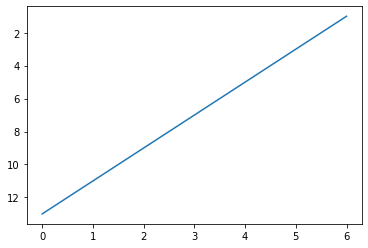

In [74]:
#from matplotlib import pyplot as plt
test = plt.plot(db['sofimshc']['staebe'][stab]['points'], db['ase'][1]['s'][0]['V'])
plt.gca().invert_yaxis()

# Überholt

In [11]:
V = np.linalg.inv(db['sofimshc']['wgv']['K']).dot(P_1)
db['sofimshc']['wgv']['k'].dot(db['sofimshc']['wgv']['a'].dot(V)) + db['sofiload']['LF'][1]['wgv']['s_0']

NameError: name 'P_1' is not defined

In [84]:
db['sofimshc']['staebe'] = calculate_staebe(db['sofimshc']['staebe'], db['sofimshc']['knoten'])
print(db['sofimshc']['staebe'])

[{'l': 0, 'r': 1, 'EI': 6000, 'EA': 1000000, 'L': 6.0, 'alpha': 0.0}, {'l': 1, 'r': 2, 'EI': 6000, 'EA': 1000000, 'L': 6.0, 'alpha': 0.0}, {'l': 2, 'r': 3, 'EI': 6000, 'EA': 1000000, 'L': 6.0, 'alpha': -90.0}]


In [85]:
feder_dict = federn(db)
db['sofimshc']['federn'] = feder_dict

a, pos = kinematic_transformation_matrix(db)
db['sofimshc']['wgv'] = dict()
db['sofimshc']['wgv']['a'] = a
db['sofimshc']['wgv']['knot_deform'] = pos
print('Größe: ', a.shape)
for row in a:
    for value in row:
        text = f'{value:+.2f}' if round(value, 5) != 0 else ' '*5
        print(text, end=" ")
    print()

k = stiffness_matrix(db)
db['sofimshc']['wgv']['k'] = k

print()
print('Größe: ', k.shape)
for row in k:
    for value in row:
        text = f'{value:+.2e}' if round(value, 5) != 0 else ' '*9
        print(text, end=" ")
    print()

K = total_stiffness_matrix(db)

print()
print('Größe: ', K.shape)
for row in K:
    for value in row:
        text = f'{value:+.2e}' if round(value, 5) != 0 else ' '*9
        print(text, end=" ")
    print()

Größe:  (10, 7)
+1.00                                     
      +0.17                               
      +0.17 +1.00                         
-1.00             +1.00                   
      -0.17 +1.00       +0.17             
      -0.17             +0.17 +1.00       
                        -1.00             
                  +0.17       +1.00       
                  +0.17             +1.00 
                              +1.00       

Größe:  (10, 10)
+1.67e+05                                                                                           
          +4.00e+03 +2.00e+03                                                                       
          +2.00e+03 +4.00e+03                                                                       
                              +1.67e+05                                                             
                                        +4.00e+03 +2.00e+03                                         
                               

In [107]:
s_0_dict = {}
P_0_dict = {}
P_quer_dict = {}

for lf in db['sofiload']['LF'].items(): 
    s_0 = np.zeros(len(db['sofimshc']['wgv']['a']))
    P_0 = np.zeros(len(db['sofimshc']['wgv']['a'][1]))
    P_quer = np.zeros(len(db['sofimshc']['wgv']['a'][1]))

    for knot in lf[1]['knot']:      #TODO Stützensenkung
        if knot['type'] == 'F':
            if (knot['nr'], 'x') in db['sofimshc']['wgv']['knot_deform']:
                index = db['sofimshc']['wgv']['knot_deform'].index((knot['nr'], 'x'))
                P_quer[index] += -np.cos(alpha)*knot['val']

            if (knot['nr'], 'z') in db['sofimshc']['wgv']['knot_deform']:
                index = db['sofimshc']['wgv']['knot_deform'].index((knot['nr'], 'z'))
                P_quer[index] += np.sin(alpha)*knot['val']
        if knot['type'] == 'M': 
            if (knot['nr'], 'y') in db['sofimshc']['wgv']['knot_deform']:
                index = db['sofimshc']['wgv']['knot_deform'].index((knot['nr'], 'y'))
                P_quer[index] += knot['val']
    
    for stab in lf[1]['stab']:      #TODO Temperatur gleichförmig, ungleichförmig, Einzellasten (mehrere superponieren)
        length = db['sofimshc']['staebe'][stab['nr']]['L']
        alpha = np.radians(db['sofimshc']['staebe'][stab['nr']]['alpha'])
        pos = stab['nr']*3

        s_0[pos] += -1/6*length*(stab['p_xl']+2*stab['p_xr'])           # N_r^0
        s_0[pos+1] += length**2/60*(3*stab['p_zl'] + 2*stab['p_zr'])    # M_l^0
        s_0[pos+2] += -length**2/60*(2*stab['p_zl'] + 3*stab['p_zr'])   # M_r^0

        knot_l = db['sofimshc']['staebe'][stab['nr']]['l']
        P_zl = length/6*(2*stab['p_zl'] + stab['p_zr'])
        P_xl = length/6*(2*stab['p_xl'] + stab['p_xr'])
        if (knot_l, 'x') in db['sofimshc']['wgv']['knot_deform']:
            index = db['sofimshc']['wgv']['knot_deform'].index((knot_l, 'x'))
            P_0[index] += np.sin(alpha)*P_zl + np.cos(alpha)*P_xl
            
        if (knot_l, 'z') in db['sofimshc']['wgv']['knot_deform']:
            index = db['sofimshc']['wgv']['knot_deform'].index((knot_l, 'z'))
            P_0[index] += np.cos(alpha)*P_zl - np.sin(alpha)*P_xl
            
            

        knot_r = db['sofimshc']['staebe'][stab['nr']]['r']
        P_zr = length/6*(stab['p_zl'] + 2*stab['p_zr'])
        P_xr = length/6*(stab['p_xl'] + 2*stab['p_xr'])
        if (knot_r, 'x') in db['sofimshc']['wgv']['knot_deform']:
            index = db['sofimshc']['wgv']['knot_deform'].index((knot_r, 'x'))
            P_0[index] += np.sin(alpha)*P_zr + np.cos(alpha)*P_xr

        if (knot_r, 'z') in db['sofimshc']['wgv']['knot_deform']:
            index = db['sofimshc']['wgv']['knot_deform'].index((knot_r, 'z'))
            P_0[index] += np.cos(alpha)*P_zr - np.sin(alpha)*P_xr  

    s_0_dict[lf[0]] = s_0
    P_0_dict[lf[0]] = P_0
    P_quer_dict[lf[0]] = P_quer

print(s_0_dict)
print(P_0_dict)
print(P_quer_dict)

for item in s_0_dict.items():
    db['sofiload']['LF'][item[0]]['wgv'] = dict()
    db['sofiload']['LF'][item[0]]['wgv']['s_0'] = item[1]

for item in P_0_dict.items():
    db['sofiload']['LF'][item[0]]['wgv']['P_0'] = item[1]

for item in P_quer_dict.items():
    db['sofiload']['LF'][item[0]]['wgv']['P_quer'] = item[1]

{1: array([ 0.,  6., -6.,  0.,  6., -6.,  0.,  0.,  0.,  0.])}
{1: array([ 0., 12.,  0.,  0.,  6.,  0.,  0.])}
{1: array([0., 0., 0., 0., 0., 0., 0.])}


In [52]:
db['sofimshc']['wgv']['knot_deform']

[(1, 'x'), (1, 'z'), (1, 'y'), (2, 'x'), (2, 'z'), (2, 'y'), (3, 'y')]

In [11]:
V_name = []
SEWG_name = []

for x in range(len(staebe)):
    stab_nr = string.ascii_lowercase[x]
    SEWG_name.extend((f'u_delta^{stab_nr}', f'tau_l^{stab_nr}', f'tau_r^{stab_nr}'))

feder_wert = len(staebe)
federn = []

for i, knot in enumerate(knoten):
    for key, value in knot['sup'].items():
        if value == 0:
            V_name.append(f'V_{key}^{i}')
        elif value > 0:
            V_name.append(f'V_{key}^{i}')
            federn.append({'knot': i, 'richtung': key, 'wert': value})
            if key == 'x':
                SEWG_name.append((f'u_delta_x^{string.ascii_lowercase[feder_wert]}'))
            elif key == 'z':
                SEWG_name.append((f'u_delta_z^{string.ascii_lowercase[feder_wert]}'))
            elif key == 'y':
                SEWG_name.append(((f'tau^{string.ascii_lowercase[feder_wert]}')))
            feder_wert += 1

print(V_name)
print(SEWG_name)
print(federn)

NameError: name 'staebe' is not defined

In [35]:
db = {
    'aqua': {
        'materialien': [
            {'E': 100000}
        ],

        'querschnitte': [
            {'h': 0.41602, 'b': 100000}
        ],
    },

    'sofimshc': {
        'knoten': [
            {'x':  0, 'z': 0, 'sup': {'x': -1, 'z': -1, 'y': -1}},
            {'x':  4, 'z': 0, 'sup': {'x':  0, 'z':  0, 'y':  0}},
            {'x':  8, 'z': 0, 'sup': {'x':  0, 'z':  0, 'y':  0}},
            {'x':  8, 'z': 5, 'sup': {'x': -1, 'z': -1, 'y':  0}},
        ],

        'staebe': [
            {'l': 0, 'r': 1, 'EI': 6000, 'EA': 1000000},
            {'l': 1, 'r': 2, 'EI': 6000, 'EA': 1000000},
            {'l': 2, 'r': 3, 'EI': 6000, 'EA': 1000000},
        ],
    },

    'sofiload': {
        'LF_Komb': {
            'G_1': {'GAMU': 1.35, 'GAMF': 1.00, 'PSI0': 1.00, 'PSI1': 1.00, 'PSI2': 1.00},
            'G_1': {'GAMU': 1.35, 'GAMF': 1.00, 'PSI0': 1.00, 'PSI1': 1.00, 'PSI2': 1.00},
            'G_1': {'GAMU': 1.35, 'GAMF': 1.00, 'PSI0': 1.00, 'PSI1': 1.00, 'PSI2': 1.00},
        },

        'LF': {
            1: {}
        }
    },

    'maxima': [

    ],

    'aqb': [

    ],
}

In [ ]:
def kinematic_transformation_matrix(db: dict) -> tuple:
    a_T = []

    #feder_wert = len(db['sofimshc']['staebe'])
    #federn = []
    
    #for i, knot in enumerate(db['sofimshc']['knoten']):
     #   for key, value in knot['sup'].items():
      #      if value > 0:
       #         federn.append({'knot': i, 'richtung': key, 'wert': value})
        #        feder_wert += 1
    pos = []

    for i, knot in enumerate(db['sofimshc']['knoten']):
        for key, value in knot['sup'].items():
            if value >= 0:
                pos.append((i, key))
                V_vek = []

                for j, stab in enumerate(db['sofimshc']['staebe']):
                    alpha = np.radians(stab['alpha'])
                    laenge = stab['L']
                    if stab['l'] == i:    
                        if key == 'x': 
                            V_vek.extend((-np.cos(alpha), -np.sin(alpha)/laenge, -np.sin(alpha)/laenge))
                        if key == 'z': 
                            V_vek.extend((np.sin(alpha), -np.cos(alpha)/laenge, -np.cos(alpha)/laenge))
                        if key == 'y': 
                            V_vek.extend((0, 1, 0))

                    elif stab['r'] == i:
                        if key == 'x': 
                            V_vek.extend((np.cos(alpha), np.sin(alpha)/laenge, np.sin(alpha)/laenge))
                        if key == 'z': 
                            V_vek.extend((-np.sin(alpha), np.cos(alpha)/laenge, np.cos(alpha)/laenge))
                        if key == 'y': 
                            V_vek.extend((0, 0, 1))
                    
                    else:
                        V_vek.extend((0, 0, 0))

                for feder in db['sofimshc']['federn']:
                    if feder['knot'] == i: 
                        if key == 'x' and feder['richtung'] == 'x': 
                            V_vek.append(1)
                        elif key == 'z' and feder['richtung'] == 'z': 
                            V_vek.append(-1)
                        elif key == 'y' and feder['richtung'] == 'y': 
                            V_vek.append(1)
                        else: 
                            V_vek.append(0)
                    else: 
                        V_vek.append(0) 
                
                a_T.append(V_vek)          

    return np.array(a_T).transpose(), pos    # kinematische Transformationsmatrix a
    